In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from NegativeClassOptimization import config 
from NegativeClassOptimization import data_similarity as ds
import seaborn as sns
import matplotlib.pyplot as plt
from NegativeClassOptimization.preprocessing import *
from pathlib import Path

In [2]:
df_affmat = pd.read_csv(config.DATA_POREBSKI_AFFMAT)
df_mllib = pd.read_csv(config.DATA_POREBSKI_MLLIB)

In [3]:
# 01b_df_kd.csv file generated in script_01c_build_experimental.py contains Kd - dissociation constant
df_kd = pd.read_csv(Path(config.DATA_BASE_PATH) / "01b_df_kd_absolut_format.csv", index_col=0)

In [4]:
df_kd.head()

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,Source,Antigen,binder_type
0,NaN,ADVAYCCTPTCAKWPEYFQWW,True,ADVAYCCTPTCAKWPEYFQWW,118.581446,NaN,HR2P_95low,HR2P,HR2P_95low
1,NaN,CDGACCDTPTCAKWPEYFQHW,True,CDGACCDTPTCAKWPEYFQHW,113.952191,NaN,HR2P_95low,HR2P,HR2P_95low
2,NaN,CDPAYYSSSRCLTWPEYFQHW,True,CDPAYYSSSRCLTWPEYFQHW,114.270451,NaN,HR2P_95low,HR2P,HR2P_95low
3,NaN,CDRAYCDTPTCAKWPEYFQHW,True,CDRAYCDTPTCAKWPEYFQHW,113.967739,NaN,HR2P_95low,HR2P,HR2P_95low
4,NaN,CDRAYCDTPTCAKWPEYFQPW,True,CDRAYCDTPTCAKWPEYFQPW,113.271742,NaN,HR2P_95low,HR2P,HR2P_95low


In [5]:
df_kd["binder_type"].value_counts()

HR2P_95low      18578
HR2P_looserX     3574
HR2P_high        2638
Name: binder_type, dtype: int64

In [6]:
df_pos = df_kd[df_kd['binder_type'] == 'HR2P_high'].sample(n=2500, random_state=42)
df_pos['y'] = 1
df_weak = df_kd[df_kd['binder_type'] == 'HR2P_looserX'].sample(n=2500, random_state=42)
df_weak['y'] = 0
df_nb = df_kd[df_kd['binder_type'] == 'HR2P_95low'].sample(n=2500, random_state=42)
df_nb['y'] = 0


In [7]:
from sklearn.model_selection import train_test_split
df_pos_train, df_pos_test = train_test_split(df_pos, test_size=0.2, random_state=42)
df_weak_train, df_weak_test = train_test_split(df_weak, test_size=0.2, random_state=42)
df_nb_train, df_nb_test = train_test_split(df_nb, test_size=0.2, random_state=42)

In [8]:
#merging positive data with negative variants
df_vs_weak_train = pd.concat([df_pos_train, df_weak_train]).reset_index(drop=True)
df_vs_weak_test = pd.concat([df_pos_test, df_weak_test]).reset_index(drop=True)
df_vs_nb_train = pd.concat([df_pos_train, df_nb_train]).reset_index(drop=True)
df_vs_nb_test = pd.concat([df_pos_test, df_nb_test]).reset_index(drop=True)

In [9]:
#leaks on Weak
df_train, df_test = df_vs_weak_train, df_vs_weak_test
pairs = ds.find_one_char_diff_pairs(df_train, df_test)
leak_weak_df = ds.get_leak_info(df_train,df_test, pairs)

#leaks of Non-binder
df_train, df_test = df_vs_nb_train, df_vs_nb_test
pairs = ds.find_one_char_diff_pairs(df_train, df_test)
leak_nb_df = ds.get_leak_info(df_train,df_test, pairs)

In [10]:
def label_concordance_count(leak_df, df_test):
    grouped_counts = leak_df.groupby(['test_Slide','label_concordance']).size().unstack(level=-1, fill_value=0)
    row_sum = grouped_counts.sum(axis=1)
    label_concordance_abundance = grouped_counts.div(row_sum, axis=0)
    label_concordance_abundance = label_concordance_abundance.sum(axis=0)/df_test.shape[0]
    return label_concordance_abundance

In [11]:
label_concordance_abundance_nb = label_concordance_count(leak_nb_df, df_vs_nb_test)
label_concordance_abundance_weak = label_concordance_count(leak_weak_df, df_vs_weak_test)

In [12]:
lc_nb = pd.DataFrame(label_concordance_abundance_nb).T
lc_nb['task'] = 'vs Non-binder'
lc_wk = pd.DataFrame(label_concordance_abundance_weak).T
lc_wk['task'] = 'vs Weak'

In [13]:
lc_nb[['++', '+-', '--', '-+']].apply(sum, axis=1)

0    0.437
dtype: float64

In [14]:
lc_wk[['++', '+-', '--', '-+']].apply(sum, axis=1)

0    0.651
dtype: float64

In [15]:
lc = pd.concat([lc_nb, lc_wk])

In [16]:
col_order = ['++', '--', '+-', '-+', 'task']
task_order =['vs Non-binder', 'vs Weak']

In [17]:
def put_numbers_to_barplt(count_df):
    for i, task in enumerate(task_order):
        base = 0
        for col in col_order[:-1]:
            y = count_df[count_df['task']==task][col].values[0].round(2)
            plt.text(x=i-0.05, y=y/2+base, s=y, size="small")
            base += y

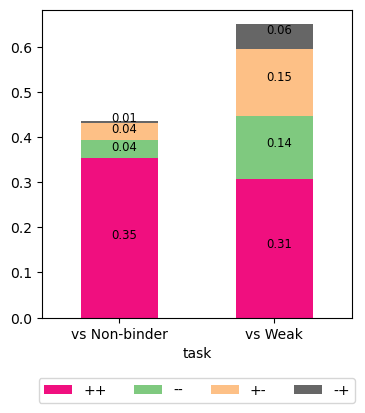

In [18]:
plt.rcParams['svg.fonttype'] = 'none'
lc[col_order].plot(kind='bar', x='task', stacked=True, color=["#F00F7F", "#7FC97F","#FDC086","#666666"], figsize=(4,4)) #colors are wrong
put_numbers_to_barplt(lc[col_order])
plt.xticks(rotation=0)
#color=["#F00F7F", "#7FC97F", "#FDC086","#666666"]#
#cmap={'++':"#F00F7F", '--': "#7FC97F", '+-': "#FDC086", "-+":"#666666"}
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4)
plt.savefig('./figures/id-ood-corr-exp.svg')

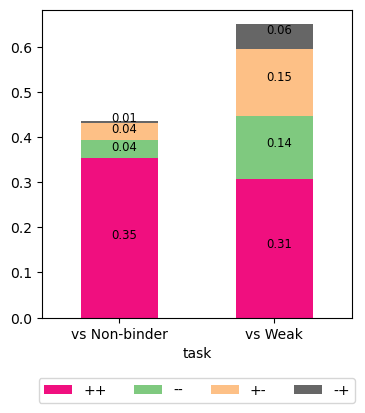

In [19]:
plt.rcParams['svg.fonttype'] = 'none'
lc[col_order].plot(kind='bar', x='task', stacked=True, color=["#F00F7F", "#7FC97F","#FDC086","#666666"], figsize=(4,4)) #colors are wrong
put_numbers_to_barplt(lc[col_order])
plt.xticks(rotation=0)
#color=["#F00F7F", "#7FC97F", "#FDC086","#666666"]#
#cmap={'++':"#F00F7F", '--': "#7FC97F", '+-': "#FDC086", "-+":"#666666"}
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4)
plt.savefig('./figures/id-ood-corr-exp.svg')

In [20]:
leak_nb_df['task'] = 'vs Non-binder'
leak_weak_df['task'] = 'vs Weak'
leak_all_df = pd.concat([leak_nb_df, leak_weak_df])

In [21]:
leak_all_df['Energy_diff_abs'] = leak_all_df['Energy_diff'].abs()

In [22]:
hue_order=['++', '--', '+-', '-+']

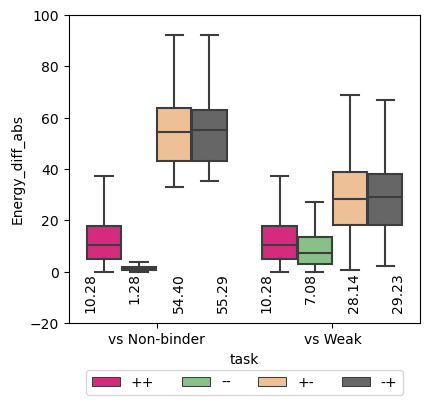

In [23]:
plt.rcParams['svg.fonttype'] = 'none'
plt.figure(figsize=(4*1.134,4))
plt.ylim([-20, 100])
sns.boxplot(leak_all_df, x='task',  y='Energy_diff_abs', hue='label_concordance', showfliers=False,\
            hue_order=hue_order, palette={"++": "#F00F7F", "--": "#7FC97F","+-": "#FDC086","-+":"#666666"})
ds.plot_median_for_energy_diff(leak_all_df, hue_order, "task", task_order) #add task as parameter

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=5)
plt.savefig('./figures/leak_eng_diff_exp.svg')